In [57]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras

from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os
import librosa
import librosa.display
import h5py
import warnings
warnings.filterwarnings('ignore')

from joblib import Parallel, delayed

## Exploratory Data Analysis

In [58]:
data = pd.read_csv("../input/urbansound8k/UrbanSound8K.csv")
dataset_path = '../input/urbansound8k/'
data.head()
print(os.listdir(dataset_path))

['fold7', 'fold1', 'fold3', 'fold5', 'fold10', 'UrbanSound8K.csv', 'fold9', 'fold8', 'fold4', 'fold2', 'fold6']


In [59]:
data.info()
data.describe()
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   slice_file_name  8732 non-null   object 
 1   fsID             8732 non-null   int64  
 2   start            8732 non-null   float64
 3   end              8732 non-null   float64
 4   salience         8732 non-null   int64  
 5   fold             8732 non-null   int64  
 6   classID          8732 non-null   int64  
 7   class            8732 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 545.9+ KB


slice_file_name    0
fsID               0
start              0
end                0
salience           0
fold               0
classID            0
class              0
dtype: int64

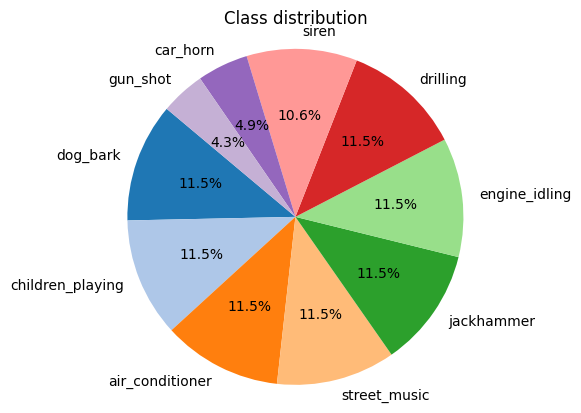

In [60]:
counts = data['class'].value_counts()

labels = counts.index
sizes = counts.values
colors = plt.cm.tab20.colors  

plt.figure()
plt.pie(
    sizes,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    startangle=140
)
plt.axis('equal')
plt.title('Class distribution')

plt.show()

## Displaying spectrograms of different classes

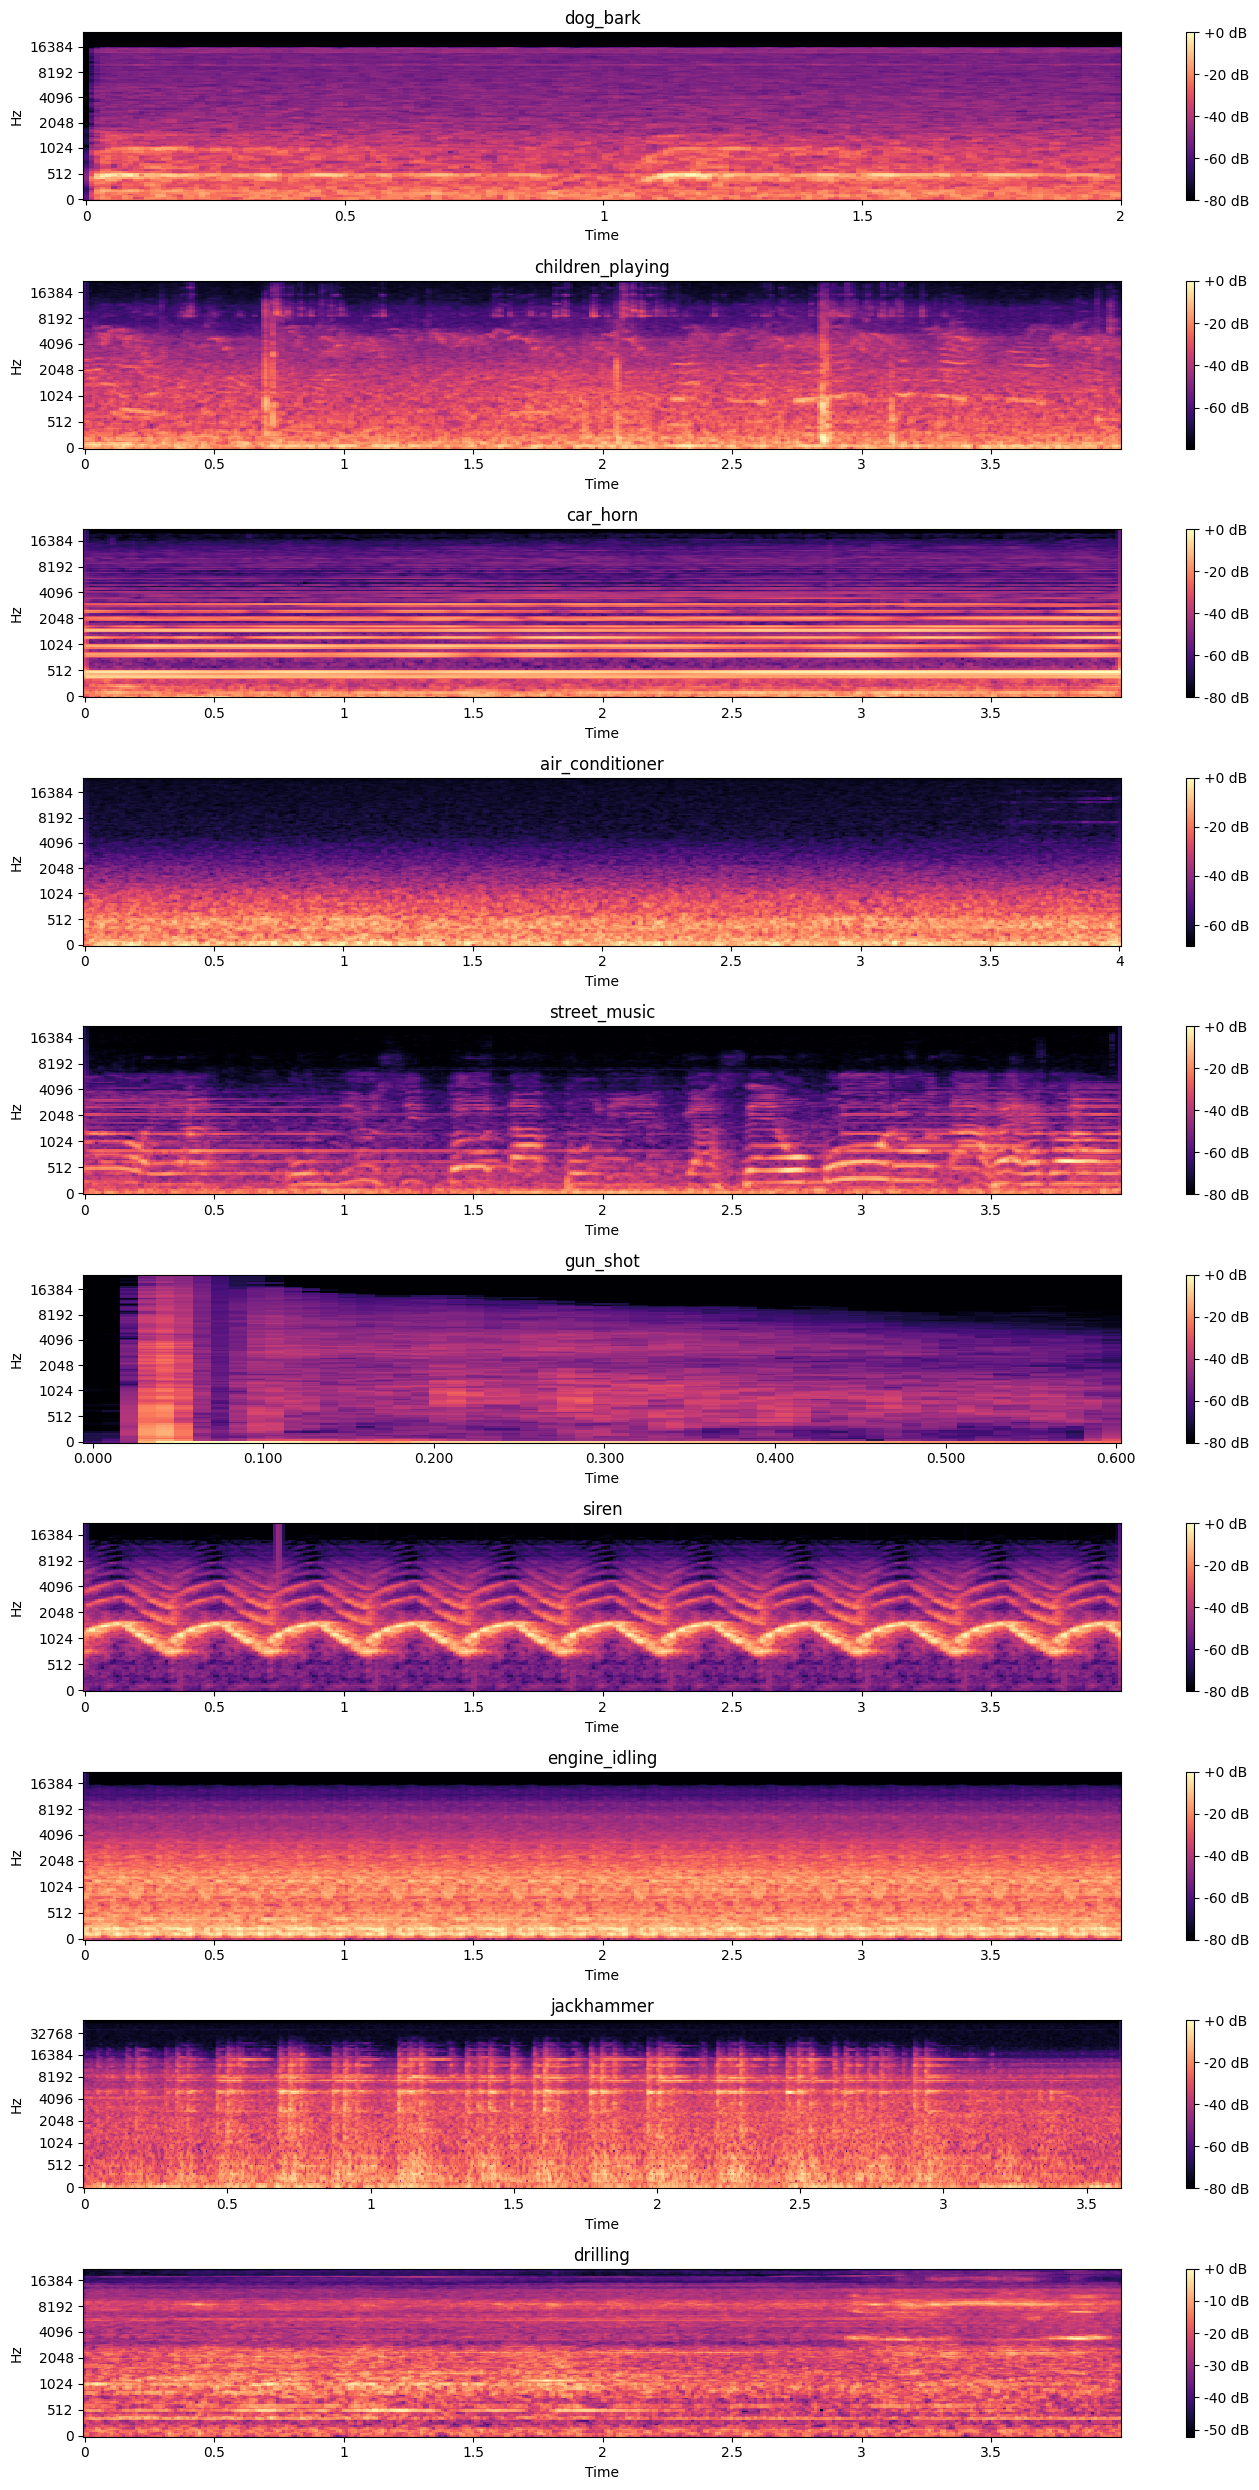

In [61]:
def plot_spectrogram_classwise(dataset_path):
    metadata_path = os.path.join(dataset_path, "UrbanSound8K.csv")

    df = pd.read_csv(metadata_path)

    classes = df['class'].unique()
    num_classes = len(classes)

    plt.figure(figsize=(14, 2.5 * num_classes))

    for i, cls in enumerate(classes):
        row = df[df['class'] == cls].sample(1).iloc[0]

        file_path = os.path.join(
            dataset_path,
            f"fold{row['fold']}",
            row['slice_file_name']
        )
        y,sr = librosa.load(file_path, sr=None)

        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        S_dB = librosa.power_to_db(S, ref=np.max)

        plt.subplot(num_classes, 1, i+1)
        librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f"{cls}")

    plt.tight_layout()
    plt.show()

plot_spectrogram_classwise(dataset_path)

## Preprocessing

In [62]:
SAMPLE_RATE = 22050
DURATION = 4.0
SAMPLES = int(SAMPLE_RATE * DURATION)

N_MELS = 128
N_FFT = 2048
HOP_LENGTH = 512

classes = [
    'air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 
    'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 
    'siren', 'street_music'
]

In [63]:
def scale_minmax(X, min=0.0, max=1.0):
    X_std = (X-X.min())/(X.max()-X.min()+1e-8)
    X_scaled = X_std * (max - min) + min
    return X_scaled

In [64]:
def preprocess_audio(row, dataset_path):
    file_path = os.path.join(dataset_path, f"fold{row['fold']}", row['slice_file_name'])
    try:
        y, _ = librosa.load(file_path, sr=SAMPLE_RATE, mono=True)
        if len(y) <SAMPLES:
            y = np.pad(y, (0, SAMPLES - len(y)))
        else:
            y = y[:SAMPLES]
        
        y = y/(np.max(np.abs(y)) + 1e-8)
        
        mel = librosa.feature.melspectrogram(y=y, sr=SAMPLE_RATE, n_fft=N_FFT, 
                                            hop_length=HOP_LENGTH, n_mels=N_MELS)
        mel_db = librosa.power_to_db(mel, ref=np.max)
        return scale_minmax(mel_db)[..., np.newaxis], row['classID']
    except Exception as e:
        return None, None

In [65]:
def save_to_h5(df, dataset_path, group_name, h5_file, n_jobs=-1, batch_size=512):
    print(f"Processing {group_name} set in parallel...")
    group = h5_file.create_group(group_name)
    sample_shape = (128, 173, 1)
    
    X_ds = group.create_dataset("X", shape=(len(df), *sample_shape), dtype='float32', compression="lzf")
    y_ds = group.create_dataset("y", shape=(len(df),), dtype='int32')

    rows = [row for _, row in df.iterrows()]

    for i in range(0, len(rows), batch_size):
        batch_rows = rows[i:i + batch_size]
        
        results = Parallel(n_jobs=n_jobs)(
            delayed(preprocess_audio)(row, dataset_path) 
            for row in tqdm(batch_rows, desc=f"Batch {i//batch_size + 1}", leave=False)
        )
        
        batch_X = []
        batch_y = []
        valid_count = 0
        
        for feat, lbl in results:
            if feat is not None:
                batch_X.append(feat)
                batch_y.append(lbl)
                valid_count += 1
        
        if batch_X:
            X_ds[i : i + valid_count] = np.array(batch_X)
            y_ds[i : i + valid_count] = np.array(batch_y)


In [66]:
SAVE_PATH = "/kaggle/working/urbansound_data.h5"
metadata_path = "/kaggle/input/urbansound8k/UrbanSound8K.csv" 
df = pd.read_csv(metadata_path)

df['relative_path']='fold'+df['fold'].astype(str)+'/'+df['slice_file_name']

train_df, test_df = train_test_split(
    df, 
    test_size=0.2, 
    random_state=42, 
    stratify=df['classID']
)

print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")

with h5py.File(SAVE_PATH, 'w') as h5_file:
    save_to_h5(train_df, dataset_path, "train", h5_file, n_jobs=-1)
    save_to_h5(test_df, dataset_path, "test", h5_file, n_jobs=-1)

Train size: 6985, Test size: 1747
Processing train set in parallel...


Processing test set in parallel...


In [67]:
with h5py.File("/kaggle/working/urbansound_data.h5", 'r') as f:
    X_train = f['train/X'][:]
    y_train = f['train/y'][:]
    X_test = f['test/X'][:]
    y_test = f['test/y'][:]

In [68]:
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(model, X_test_data, y_test_true, model_name, class_names):
    print(f"\n{'='*20} {model_name} Evaluation {'='*20}")
    
    y_pred_probs = model.predict(X_test_data)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    
    if len(y_test_true.shape) > 1:
        y_test_true_labels = np.argmax(y_test_true, axis=1)
    else:
        y_test_true_labels = y_test_true

    print(classification_report(y_test_true_labels, y_pred_classes, target_names=class_names))
    
    loss, acc = model.evaluate(X_test_data, y_test_true, verbose=0)
    print(f"Final Test Loss: {loss:.4f}")
    print(f"Final Test Accuracy: {acc:.4f}")
    
    cm = confusion_matrix(y_test_true_labels, y_pred_classes)
    plt.figure(figsize=(12, 9))
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names)
    
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()


## CNN

In [69]:
from tensorflow.keras import layers, models, Input

def build_cnn(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(pool_size = (2,2)),
        layers.BatchNormalization(),
        
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
cnn_model = build_cnn(input_shape)

cnn_model.fit(X_train, y_train, batch_size = 32, epochs = 30)

Epoch 1/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.2022 - loss: 6.7571
Epoch 2/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.2152 - loss: 2.7393
Epoch 3/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.2279 - loss: 2.1207
Epoch 4/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.2800 - loss: 2.0734
Epoch 5/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.3240 - loss: 1.9033
Epoch 6/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.3547 - loss: 1.7906
Epoch 7/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.3655 - loss: 1.7839
Epoch 8/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.4264 - loss: 1.5921
Epoch 9/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.4258 - loss: 1.5866
Epoch 10/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.4664 - loss: 1.5367
Epoch 11/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.4967 - loss: 1.3545
Epoch 12/30
219/219 ━━━━━━━━━━━━━━━━━━━━


==================== CNN Evaluation ====================
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
                  precision    recall  f1-score   support

 air_conditioner       0.73      0.56      0.64       200
        car_horn       0.93      0.87      0.90        86
children_playing       0.83      0.42      0.56       200
        dog_bark       0.69      0.82      0.75       200
        drilling       0.91      0.71      0.80       200
   engine_idling       0.59      0.86      0.70       200
        gun_shot       0.79      0.97      0.87        75
      jackhammer       0.86      0.84      0.85       200
           siren       0.63      0.92      0.75       186
    street_music       0.88      0.69      0.77       200

        accuracy                           0.75      1747
       macro avg       0.78      0.77      0.76      1747
    weighted avg       0.77      0.75      0.74      1747

Final Test Loss: 1.3185
Final Test Accuracy: 0.7476


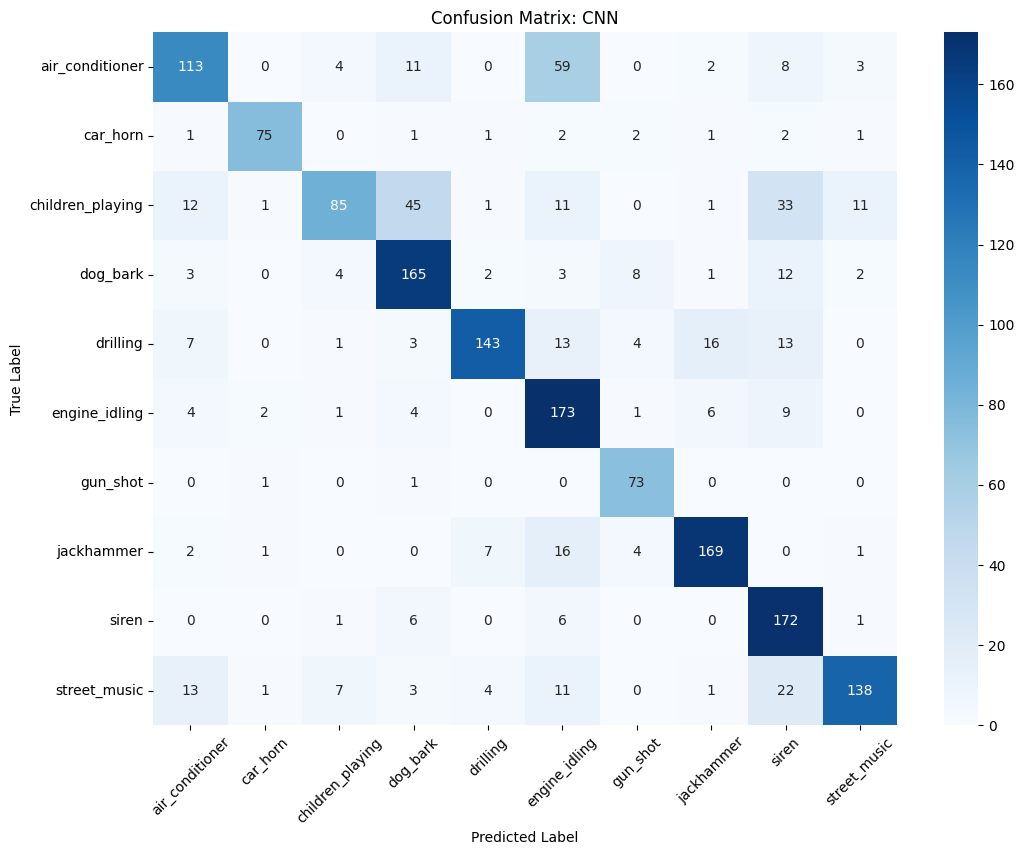

In [70]:
X_test_cnn = X_test
evaluate_model(cnn_model, X_test_cnn, y_test, "CNN", classes)

## LSTM

In [71]:
from tensorflow.keras.utils import to_categorical
y_train_lstm = to_categorical(y_train)
def build_lstm(input_shape=(173, 128)):
    model = models.Sequential([
        layers.LSTM(128, input_shape=input_shape, return_sequences=True),
        layers.Dropout(0.3),
        layers.LSTM(64),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(y_train_lstm.shape[1], activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

X_train_lstm = X_train.reshape(-1, 173, 128) 
lstm_model = build_lstm()

lstm_model.fit(X_train_lstm, y_train, batch_size = 32, epochs = 100)

Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.1719 - loss: 2.1454
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.2566 - loss: 1.8996
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.3014 - loss: 1.8312
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.2956 - loss: 1.8003
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.3409 - loss: 1.7416
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.3075 - loss: 1.7510
Epoch 7/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.3428 - loss: 1.6954
Epoch 8/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.3418 - loss: 1.6964
Epoch 9/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.3677 - loss: 1.6539
Epoch 10/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.3766 - loss: 1.6120
Epoch 11/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.4055 - loss: 1.5843
Epoch 12/100
219/219 ━━━━━━━━━


==================== LSTM Evaluation ====================
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
                  precision    recall  f1-score   support

 air_conditioner       0.83      0.93      0.88       200
        car_horn       0.70      0.66      0.68        86
children_playing       0.81      0.78      0.80       200
        dog_bark       0.77      0.72      0.75       200
        drilling       0.84      0.74      0.79       200
   engine_idling       0.90      0.89      0.89       200
        gun_shot       0.84      0.89      0.86        75
      jackhammer       0.83      0.86      0.85       200
           siren       0.84      0.84      0.84       186
    street_music       0.76      0.81      0.79       200

        accuracy                           0.82      1747
       macro avg       0.81      0.81      0.81      1747
    weighted avg       0.82      0.82      0.82      1747

Final Test Loss: 0.7619
Final Test Accuracy: 0.8185


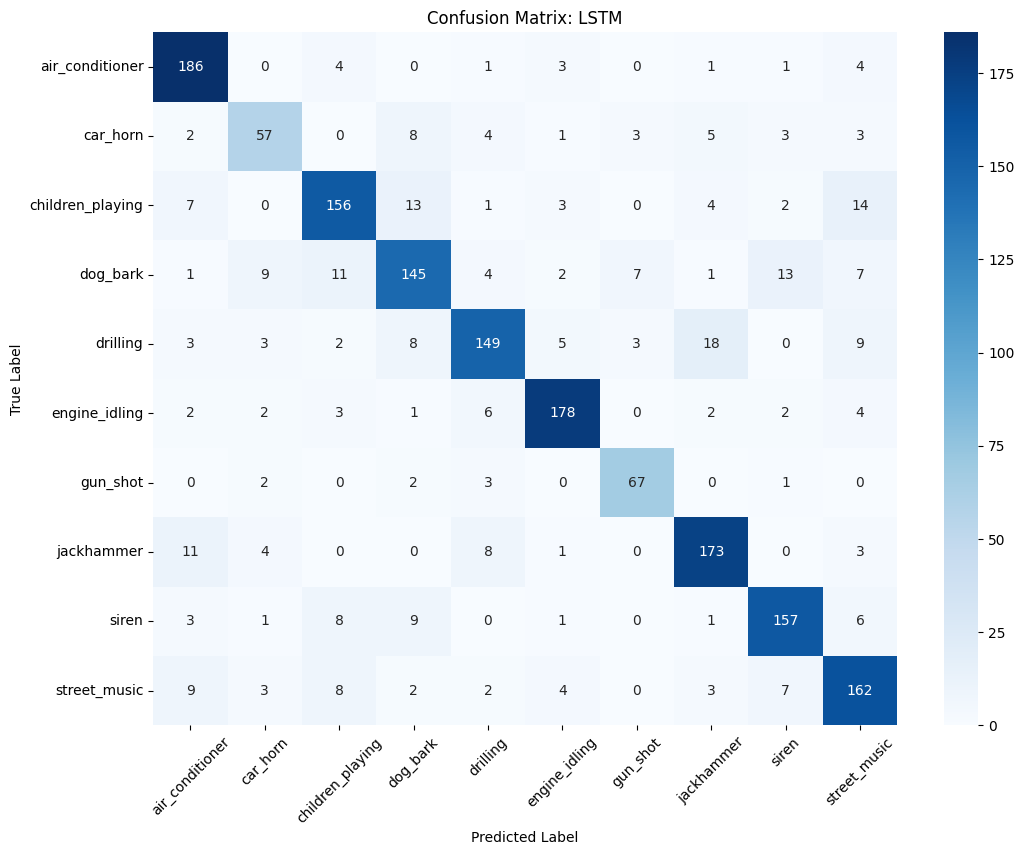

In [72]:
X_test_lstm = X_test.reshape(-1, 173, 128)
evaluate_model(lstm_model, X_test_lstm, y_test, "LSTM", classes)

## Random Forest

In [73]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

rf_model = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)
rf_model.fit(X_train_flat, y_train)
y_pred = rf_model.predict(X_test_flat)

acc = accuracy_score(y_test, y_pred)

print(f"\nAccuracy: {acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=classes))


Accuracy: 0.7224

Classification Report:
                  precision    recall  f1-score   support

 air_conditioner       0.77      0.81      0.79       200
        car_horn       0.79      0.57      0.66        86
children_playing       0.61      0.52      0.56       200
        dog_bark       0.74      0.72      0.73       200
        drilling       0.76      0.72      0.74       200
   engine_idling       0.76      0.80      0.78       200
        gun_shot       0.84      0.96      0.89        75
      jackhammer       0.67      0.81      0.73       200
           siren       0.86      0.72      0.78       186
    street_music       0.59      0.67      0.63       200

        accuracy                           0.72      1747
       macro avg       0.74      0.73      0.73      1747
    weighted avg       0.73      0.72      0.72      1747



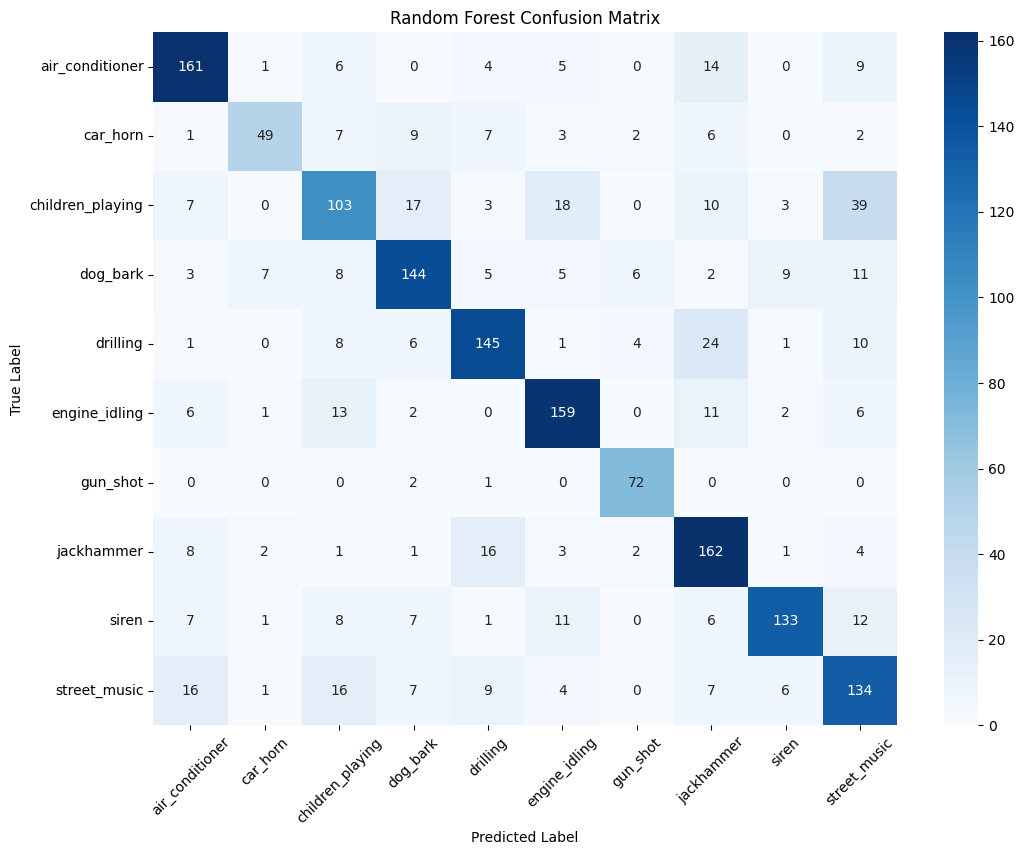

In [74]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 9))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes)
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.show()